# EDA: fraud detection - Test data for submission to Zindi
### Fraud Detection in Electricity and Gas Consumption Challenge from Zindi
### Detect clients commiting fraud in Tunisia regarding their electricity and gas consumption based on their billing history 

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import matplotlib.pyplot as plt
import joblib

from eda_tables import explore
import eda_viz as ev 


import data first check

In [2]:
#import data
client_raw = pd.read_csv('data/client_test.csv')
invoice_raw = pd.read_csv('data/invoice_test.csv')

## Data Exploration 

In [3]:
#first info including missing values and duplicates
explore(invoice_raw)

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1939730 entries, 0 to 1939729
Data columns (total 16 columns):
 #   Column                Dtype 
---  ------                ----- 
 0   client_id             object
 1   invoice_date          object
 2   tarif_type            int64 
 3   counter_number        int64 
 4   counter_statue        int64 
 5   counter_code          int64 
 6   reading_remarque      int64 
 7   counter_coefficient   int64 
 8   consommation_level_1  int64 
 9   consommation_level_2  int64 
 10  consommation_level_3  int64 
 11  consommation_level_4  int64 
 12  old_index             int64 
 13  new_index             int64 
 14  months_number         int64 
 15  counter_type          object
dtypes: int64(13), object(3)
memory usage: 236.8+ MB

 First 5 rows: 
        client_id invoice_date  tarif_type  counter_number  counter_statue  \
0  test_Client_0   2018-03-16          11          651208               0   
1  test_Client_0   2014-03-21

In [4]:
#first info including missing values and duplicates
explore(client_raw)

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   disrict        58069 non-null  int64 
 1   client_id      58069 non-null  object
 2   client_catg    58069 non-null  int64 
 3   region         58069 non-null  int64 
 4   creation_date  58069 non-null  object
dtypes: int64(3), object(2)
memory usage: 2.2+ MB

 First 5 rows: 
    disrict         client_id  client_catg  region creation_date
0       62     test_Client_0           11     307    28/05/2002
1       69     test_Client_1           11     103    06/08/2009
2       62    test_Client_10           11     310    07/04/2004
3       60   test_Client_100           11     101    08/10/1992
4       62  test_Client_1000           11     301    21/07/1977

 Descriptive statistics: 
             disrict   client_catg        region
count  58069.000000  58069.000000  58069.0

In [5]:
# renaming some columns
client_raw = client_raw.rename(columns={'disrict': 'district'})

invoice_raw = invoice_raw.rename(columns={'consommation_level_1': 'CL_1', 'consommation_level_2': 'CL_2',
                                          'consommation_level_3': 'CL_3', 'consommation_level_4': 'CL_4'})

In [6]:
#client value counts
client_cat = client_raw[['district', 'client_catg', 'region']]
ev.categorical_value_counts(client_cat)


 Value counts for categorical features: 
         Feature  Value  Count
4   client_catg   11.0  56305
5   client_catg   12.0   1054
6   client_catg   51.0    710
2      district   60.0  13696
0      district   62.0  17389
3      district   63.0  12296
1      district   69.0  14688
7        region  101.0  14480
12       region  103.0   3848
8        region  104.0   5558
24       region  105.0    678
26       region  106.0    325
10       region  107.0   4257
30       region  206.0     22
11       region  301.0   4181
17       region  302.0   1781
13       region  303.0   2615
18       region  304.0   1669
21       region  305.0   1162
14       region  306.0   2596
20       region  307.0   1510
25       region  308.0    341
19       region  309.0   1614
15       region  310.0   1973
9        region  311.0   5265
16       region  312.0   1840
22       region  313.0    894
23       region  371.0    881
27       region  372.0    262
28       region  379.0    258
29       region  399.0     

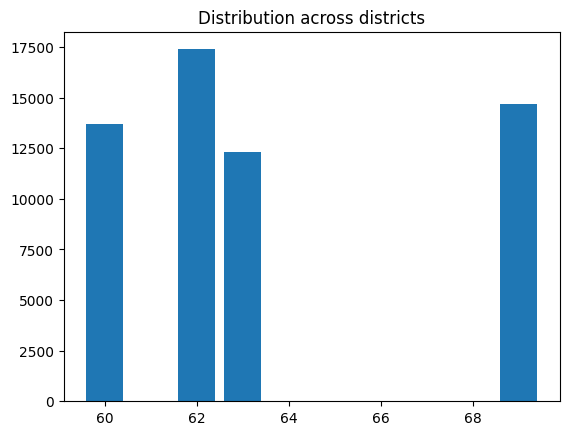

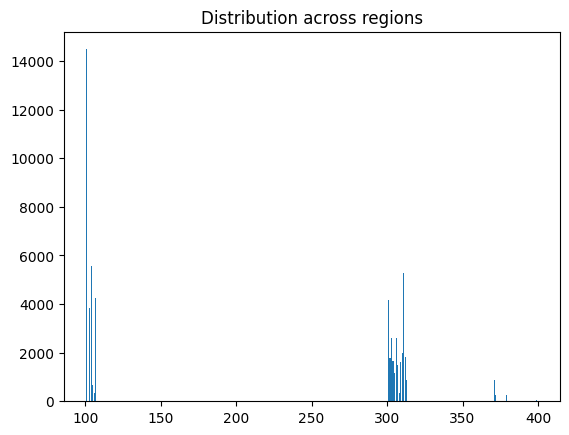

In [7]:
# Distribution of clients per district and region
for col in ['district','region']:
    region = client_raw.groupby([col])['client_id'].count()
    plt.bar(x=region.index, height=region.values)
    plt.title('Distribution across ' + col +'s')
    plt.show()

In [8]:
#invoice value counts
invoice_cat = invoice_raw[['tarif_type', 'counter_statue', 'counter_code', 'reading_remarque',
                           'counter_coefficient','counter_type']]

ev.categorical_value_counts(invoice_cat)


 Value counts for categorical features: 
          Feature Value   Count
23  counter_code   5.0  581520
30  counter_code  10.0   13934
50  counter_code  16.0      96
32  counter_code  25.0    6845
38  counter_code  40.0    1365
..           ...   ...     ...
8     tarif_type  29.0    5035
14    tarif_type  30.0       2
1     tarif_type  40.0  595448
12    tarif_type  42.0      10
4     tarif_type  45.0    8476

[74 rows x 3 columns]


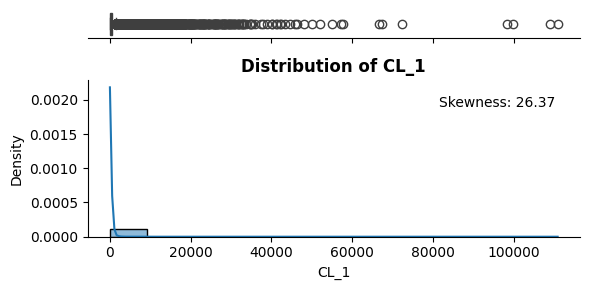

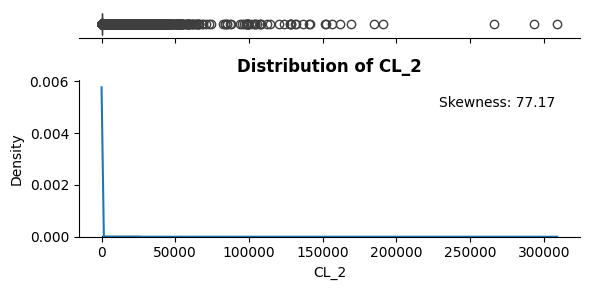

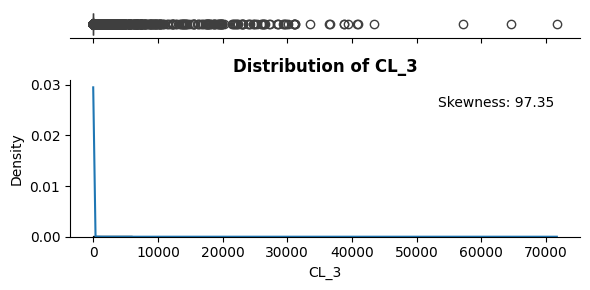

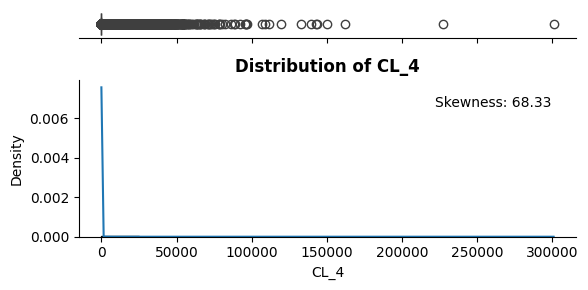

In [9]:
CLs = invoice_raw[['CL_1','CL_2','CL_3','CL_4']]
ev.plot_distributions(CLs)

Remove duplicates, NaNs, outliers

In [10]:
#no NaNs in the data

In [11]:
# remove duplicates
invoice_cleaned = invoice_raw.drop_duplicates()

In [12]:
#remove extreme outliers (1% and 99% quantile, instead of e.g. z-score, due to extreme skewness)
for col in ['CL_1', 'CL_2', 'CL_3', 'CL_4']:
    lower_bound = invoice_cleaned[col].quantile(0.01)
    upper_bound = invoice_cleaned[col].quantile(0.99)
    invoice_filtered = invoice_cleaned[(invoice_cleaned[col] >= lower_bound) & (invoice_cleaned[col] <= upper_bound)]


### feature engineering

In [13]:
# create additional values
CLs = ['CL_1','CL_2','CL_3','CL_4']

for CL in CLs: 
    CL_diff = f'diff_{CL}'
    inc_diff = f'inc_{CL}'
    rel_diff = f'rel_diff_{CL}'
    large_diff = f'large_diff_{CL}'
    invoice_filtered[CL] = invoice_filtered[CL].replace(0, 1e-9)  # Replaces 0 with a tiny number

    invoice_filtered[CL_diff] = invoice_filtered.groupby('client_id')[CL].diff().fillna(0)  
    invoice_filtered[inc_diff] = (invoice_filtered.groupby('client_id')[CL].diff().fillna(0) > 0).astype(int)
    invoice_filtered[rel_diff] = invoice_filtered.groupby('client_id')[CL].pct_change().fillna(0) 
    invoice_filtered[large_diff] = (invoice_filtered.groupby('client_id')[CL].pct_change().fillna(0) > invoice_filtered[CL].quantile(0.75) ).astype(int) 

print(invoice_filtered.head(10))


       client_id invoice_date  tarif_type  counter_number  counter_statue  \
0  test_Client_0   2018-03-16          11          651208               0   
1  test_Client_0   2014-03-21          11          651208               0   
2  test_Client_0   2014-07-17          11          651208               0   
3  test_Client_0   2015-07-13          11          651208               0   
4  test_Client_0   2016-07-19          11          651208               0   
5  test_Client_0   2012-11-22          11          651208               0   
6  test_Client_0   2018-11-22          11          651208               0   
7  test_Client_0   2019-07-23          11          651208               0   
8  test_Client_0   2008-03-24          11          651208               0   
9  test_Client_0   2011-11-16          11          651208               0   

   counter_code  reading_remarque  counter_coefficient          CL_1  \
0           203                 8                    1  7.550000e+02   
1       

In [14]:
def majority_or_single(series):
    if len(series) == 1:
        return series.iloc[0]  # Take the single value if only one invoice
    counts = series.value_counts()
    if len(counts) > 1 and counts.iloc[0] == counts.iloc[1]:
        return 1  # If there's a tie, take True (1)
    return counts.idxmax()  # Otherwise, take the most frequent value (mode)

# Define custom function to calculate the percentage of 1s 
def percentage_of_ones(series):
    return (series.sum() / len(series)) 


# Aggregate diff_features
diff_features_bool = invoice_filtered.groupby('client_id')[['inc_CL_1','inc_CL_2','inc_CL_3','inc_CL_4',
                                                            'large_diff_CL_1','large_diff_CL_2','large_diff_CL_3','large_diff_CL_4'
                                                            ]].agg(majority_or_single).reset_index()
diff_features_rel = invoice_filtered.groupby('client_id')[['inc_CL_1','inc_CL_2','inc_CL_3','inc_CL_4',
                                                           'large_diff_CL_1','large_diff_CL_2','large_diff_CL_3','large_diff_CL_4'
                                                           ]].agg(percentage_of_ones).reset_index()
# Ensure the values are integers
diff_features_bool[['inc_CL_1','inc_CL_2','inc_CL_3','inc_CL_4',
               'large_diff_CL_1','large_diff_CL_2','large_diff_CL_3','large_diff_CL_4'
               ]] = diff_features_bool[[
                   'inc_CL_1','inc_CL_2','inc_CL_3','inc_CL_4',
                   'large_diff_CL_1','large_diff_CL_2','large_diff_CL_3','large_diff_CL_4'
               ]].astype(int)

# Add suffix to every column name except client_id
diff_features_rel = diff_features_rel.rename(columns=lambda col_name: col_name if col_name == 'client_id' else col_name + '_rel')

In [15]:
# Group by column 'client_id' and calculate the mean of consommation_levels
mean_result = invoice_filtered.groupby('client_id')[['CL_1','CL_2','CL_3','CL_4']].mean().reset_index() 
# Count the number of elements in each group 
count_result = invoice_filtered.groupby('client_id')[['CL_1','CL_2','CL_3','CL_4']].size().reset_index(name='no_invoices') 

# Merge the mean and count results 
merged_invoice_1 = pd.merge(mean_result, count_result,  on='client_id')  
merged_invoice_2 = pd.merge(merged_invoice_1 , diff_features_bool,  on='client_id')  
merged_invoice = pd.merge(merged_invoice_2, diff_features_rel,  on='client_id')  

In [16]:
client = client_raw # nothing to clean, filter, etc in client data

In [17]:
#merge dfs
df = client.merge(merged_invoice, how='left', on= 'client_id')

df.shape[1] == merged_invoice.shape[1] + client.shape[1]-1 # ncol equal? Yes!

True

In [18]:
# create date columns
df['creation_date'] = pd.to_datetime(df['creation_date'])
df['day'] = df['creation_date'].dt.day.apply(lambda x: f'{x:02d}')
df['month'] = df['creation_date'].dt.month.apply(lambda x: f'{x:02d}')
df['year'] = df['creation_date'].dt.year
df['date_int'] = df[['year', 'month', 'day']].apply(lambda row: ''.join(row.values.astype(str)), axis=1)

General information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58069 entries, 0 to 58068
Data columns (total 30 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   district             58069 non-null  int64         
 1   client_id            58069 non-null  object        
 2   client_catg          58069 non-null  int64         
 3   region               58069 non-null  int64         
 4   creation_date        58069 non-null  datetime64[ns]
 5   CL_1                 57989 non-null  float64       
 6   CL_2                 57989 non-null  float64       
 7   CL_3                 57989 non-null  float64       
 8   CL_4                 57989 non-null  float64       
 9   no_invoices          57989 non-null  float64       
 10  inc_CL_1             57989 non-null  float64       
 11  inc_CL_2             57989 non-null  float64       
 12  inc_CL_3             57989 non-null  float64       
 13  inc_CL_4  

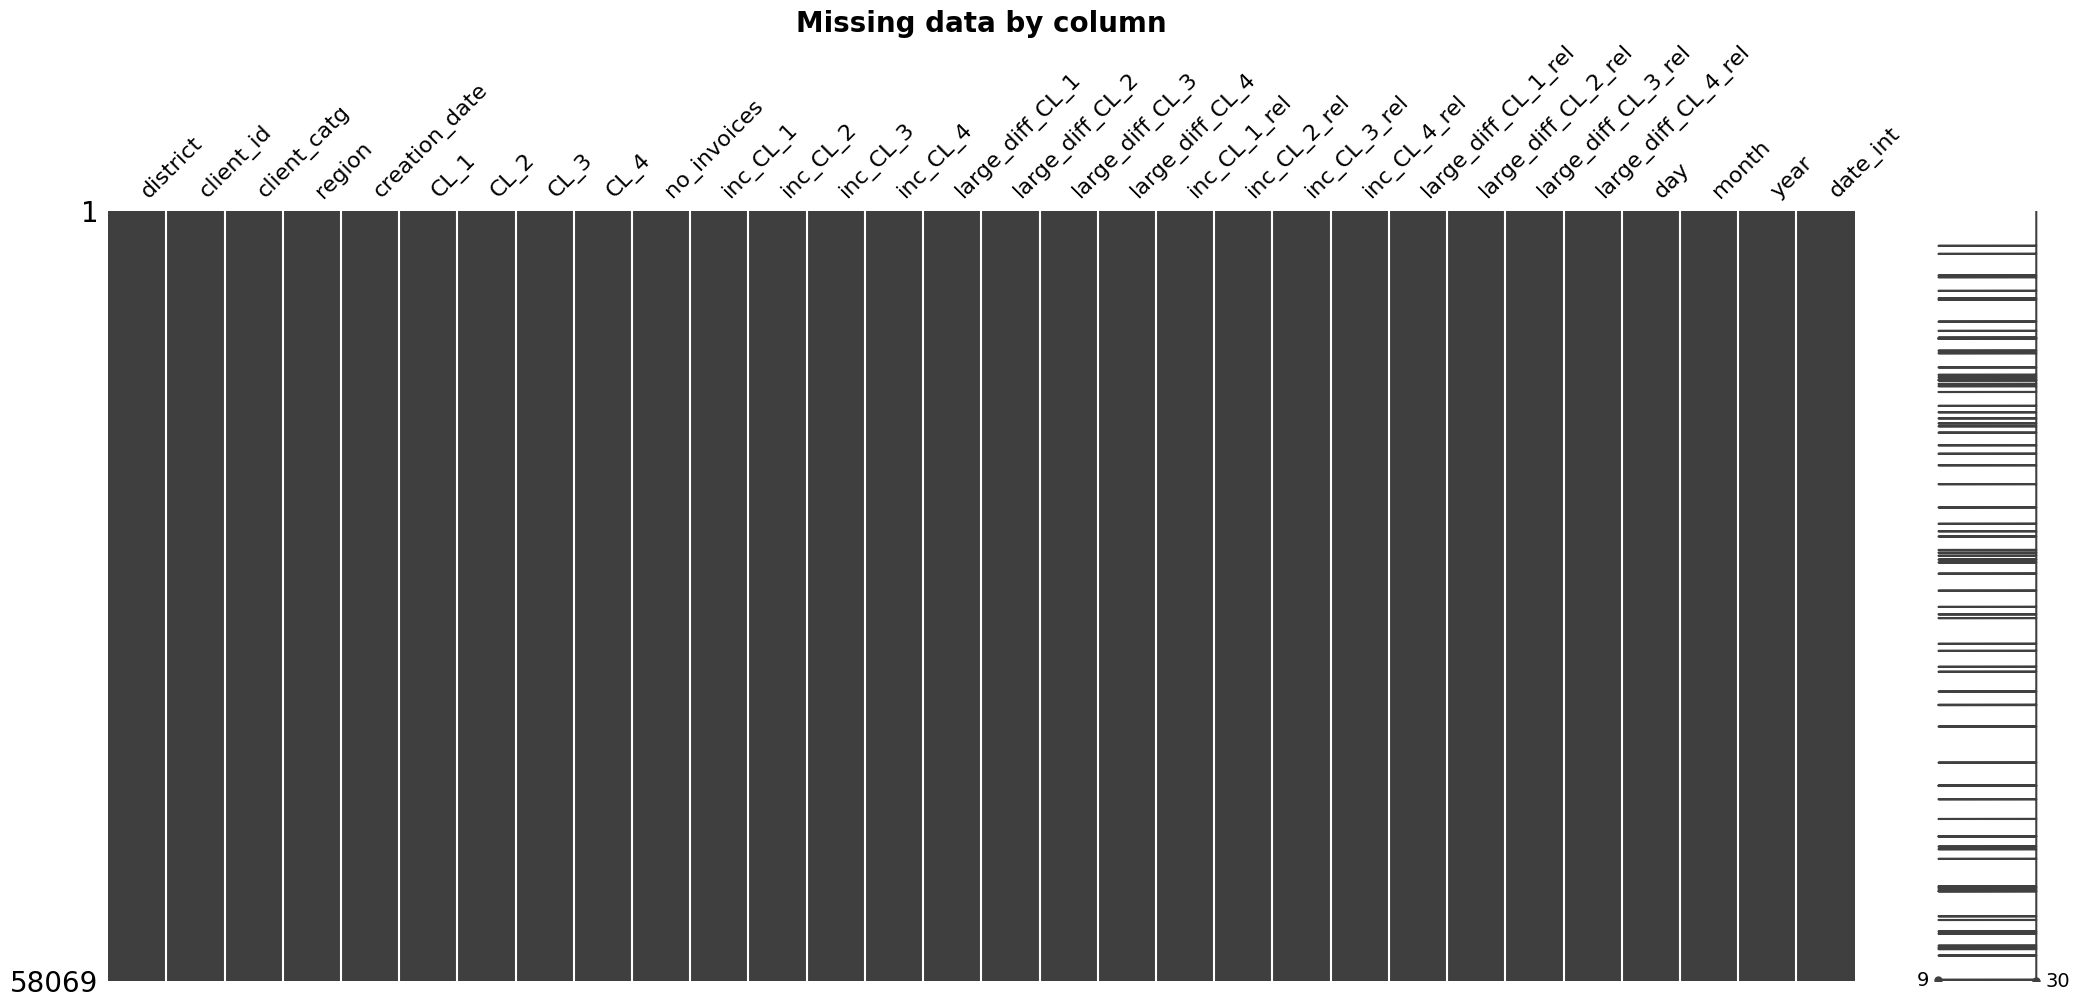

In [19]:
# final check
explore(df)
# missing values, no of unique client ids in df 'client' > no of unique client ids in df 'merged_invoice'
# --> remove rows with na
df = df.dropna()

In [20]:
# save df as csv

df.to_csv('data/merged_test.csv', index=False)

# Prediction for submission

In [21]:
df = pd.read_csv('data/merged_test.csv')

df['creation_date'] = pd.to_datetime(df['creation_date'])

df['day'] = df['day'].astype(int)
df['month'] = df['month'].astype(int)
df['year'] = df['year'].astype(int)
df['date_int'] = df[['date_int']].astype(int)

In [22]:
X= df.drop(columns=['client_id','creation_date' ]).copy()

numerical_cols = ['CL_1', 'CL_2', 'CL_3', 'CL_4',
                  'inc_CL_1_rel', 'inc_CL_2_rel', 'inc_CL_3_rel', 'inc_CL_4_rel',
                  'large_diff_CL_1_rel', 'large_diff_CL_2_rel', 'large_diff_CL_3_rel','large_diff_CL_4_rel',
                  'no_invoices','day', 'month', 'year', 'date_int']
categorical_cols = ['district', 'client_catg', 'region'] 

preprocessor = joblib.load("pretrained_models/preprocessor.pkl")

#one-hot-encoding
X_encoded = preprocessor.transform(X)
# one-hot encoded feature names from training
ohe_feature_names = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_cols)

# Combine with numerical column names
all_feature_names = numerical_cols + list(ohe_feature_names)

# Convert to df
X_encoded = pd.DataFrame(X_encoded, columns=all_feature_names, index=X.index)

#print("Encoded Training DataFrame: \n", X_encoded)

In [23]:
#predict 
best_model = joblib.load("pretrained_models/best_xgb_model.pkl")
best_threshold = joblib.load("pretrained_models/best_threshold.pkl")

y_probs = best_model.predict_proba(X_encoded)[:, 1]
y_pred_best = (y_probs > best_threshold).astype(int)

predictions = pd.DataFrame({'client_id': df.client_id, 'prediction': y_pred_best})
submission_file = pd.DataFrame({'client_id': df.client_id, 'target': y_probs})

df.to_csv('data/submission_file.csv', index=False)
